In [3]:
#!/usr/bin/python

'''
A program for analysing Mach-Zehnder interferometer measurements and extracting laser linewidths
A. J. McCulloch, September 2019
'''

####################################################################################################
# Import modules
####################################################################################################
import numpy as np
import os
import glob
import csv
from cycler import cycler
from csv import reader
from matplotlib import pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit, leastsq

####################################################################################################
# Define classes
####################################################################################################

####################################################################################################
# MOGTrace class for trace files from the mognoise evaluation board (Analogue Devices AD7760 ADC)
class MOGTrace():
    def __init__(self, filename):
        self.metadata = []
        self.name = filename

        x = []
        y = []
        item = []

        read = reader(open(filename, "r"), delimiter=",")

        for line in read:
            try:
                float(line[0])
            except ValueError:
                # If the first element of a line is a #, it is metadata
                if line[0][0] == '#':
                    # Clean the metadata
                    for i in line:
                        if i[0] == '#':
                            i = i.replace('#','')
                        i = i.strip()
                        item.append(i)
                else:
                    raise Exception("Something is wrong with the MOGtrace formatting.")

                self.metadata = item
            else:
                # The first item is a number

                # We've reached the data.
                try:
                    x.append(float(line[0]))
                except ValueError:
                    # Sometimes we have Euro numbers with , instead of .
                    x.append(float(line[0].replace(',', '.')))

                try:
                    y.append(float(line[1]))
                except ValueError:
                    # Sometimes we have Euro numbers with , instead of .
                    y.append(float(line[1].replace(',', '.')))

        self.x = np.array(x)
        self.y = np.array(y)

####################################################################################################
# Returns a plot of trace
# To subtract a background, include a second trace file to be subtracted
def traceplot(trace, background = None, savefig = False):
    
    fig, ax = plt.subplots() # Initialise figure and axes
    
    ax.plot(trace.x, trace.y, linestyle = '-', linewidth = 1, alpha = .33, label = 'Signal') # Plot the trace
    
    # Subtract a backgound
    if background != None:
        yvals = trace.y - background.y + np.median(background.y)
        ax.plot(background.x, background.y, linestyle = '-', linewidth = 1, alpha = .33, label = 'Background') # Plot the trace
        ax.plot(trace.x, yvals, linestyle = '-', linewidth = 1.5, alpha = 1, label = 'Subtracted') # Plot the trace
        plt.legend(fontsize=16) # Include a plot legend
    
    # Plot parameters
    plt.xlim((trace.x[0], trace.x[-1])) # Set the plot limits
    plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
    

    plt.grid(which = 'major') # Include major gridlines
    plt.grid(which = 'minor', linewidth = .1, alpha = 1) # Include minor gridlines

    plt.title('Demodulated Mach-Zehnder beatnote', fontsize=32) # Set the figure title
    plt.xlabel('Frequency [Hz]', fontsize=24) # Set the x-axis label
    plt.ylabel('Power spectral density [dBm/Hz]', fontsize=24) # Set the y-axis label
    plt.xticks(size = 18) # Set the size of the x-axis markers
    plt.yticks(size = 18) # Set the size of the y-axis markers
    plt.xscale('log') # Make the x axis logrithmically scaled
    
    # Save the figure
    if savefig == True:
        plt.savefig('output.pdf', bbox_inches='tight') # Save a .pdf of the figure

    plt.show() # Show the figure
    
####################################################################################################
# Returns the V_rms value calculated from the area under the PSD curve between frequencies lowerbound and upperbound
def getVrms(trace, lowerbound, upperbound, doplot = False):
    # Convert PSD in dBm/Hz to V_rms^2/Hz
    dbmtov = lambda p: (50*1e-3)*(10 ** (p/10))
    # Power spectral density (in V_rms^2/Hz)
    psd = dbmtov(trace.y)

    if doplot == True:
        # Set the plot parameters
        plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
        plt.title("Demodulated Mach-Zehnder beatnote", fontsize=32) # Set the figure title
        plt.xlabel("Frequency [Hz]", fontsize=24) # Set the x-axis label
        plt.ylabel("Power spectral density [$mV^2$/Hz]", fontsize=24) # Set the y-axis label
        plt.xticks(size = 18) # Set the size of the x-axis markers
        plt.yticks(size = 18) # Set the size of the y-axis markers

        plt.plot(trace.x, dbmtov(trace.y)/1e-6, linewidth = 2, alpha = .75)
        plt.xscale('log')
        
    # Set upper and lower limits for integration
    f_low = lowerbound
    f_high = upperbound
    f_vals = trace.x[(trace.x > f_low ) & (trace.x < f_high)] # Select frequency values inbetween the limits
    # Return the indexes for the array to integrate
    findindex = lambda x: [int(np.where(x == f_vals[0])[0]), int(np.where(x == f_vals[-1])[0]) + 1]
    totake = findindex(trace.x)
    # Integrate the PSD
    area = integrate.simps(psd[totake[0]:totake[1]], f_vals) # Integrate the PSD within the bounds
    vrms = np.sqrt(area) # Take the square root of the result
    
    return vrms

####################################################################################################
# Returns the V_rms value calculated from the area under the PSD curve between frequencies lowerbound and upperbound
def MZIrunner(folder):
    cwd = os.getcwd() # Current working directoy
    # If you look at a .pdf and run this again, you will get a permissions error; however the cwd should always be reset
    try:
        newdir = cwd + '\\' + folder # Working directory for scans
        os.chdir(newdir) # Set the working directy to the new directory
        spectra = glob.glob('*binned.csv') # Find .csv files in the specified folder

        # Make a plot of PSD
        fig, ax = plt.subplots() # Initialise figure and axes

        # Initialise the list of results
        file = []
        vRMScalib = []
        vRMSlinewidth = []
        linewidths = []
        FSR = 20e6 # Free spectral range of the fibre

        # Loop over spectra
        for spec in spectra:
            trace = MOGTrace(spec) # Import the traces
            ax.plot(trace.x, trace.y, linestyle = '-', linewidth = 1, alpha = .75, label = spec[:-10]) # Plot the traces

            if spec[:-10].lower() != 'background':
                vc = getVrms(trace, 25, 35) # Get the value of V_rms for the 30 Hz peak
                vl = getVrms(trace, 50, 1e5) # Get the value of V_rms up to 100 kHz

                file.append(spec[:-10]) # Laser name
                vRMScalib.append(vc) # Get the value of V_rms for the 30 Hz peak
                vRMSlinewidth.append(vl) # Get the value of V_rms up to 100 kHz
                lwidth = lambda r: r * FSR/(2 * np.pi) # Calculate the linewidth from the ratio of voltages
                linewidths.append(lwidth(vl/vc))

                print('Laser linewidth of {:s} determined to be {:.2f} kHz. \nRMS values of voltage were {:.2f} and {:.2f} mV @ 30 Hz and up to 100 kHz respectively\n'.format(file[-1], linewidths[-1]/1e3, vRMScalib[-1]/1e-3, vRMSlinewidth[-1]/1e-3))

        # V_RMS results
        header = ['File', 'V_RMS (30 Hz)', ' V_RMS (linewidth)', 'linewidth'] # Header for output
        output = [header] + np.transpose([file, vRMScalib, vRMSlinewidth, linewidths]).tolist() # Output cotent formatted for .csv

        # Export list of summary results
        with open("Summary.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(output)

        # Plot parameters
        plt.xlim((trace.x[0], trace.x[-1])) # Set the plot limits
        plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
        plt.legend(fontsize=16) # Include a plot legend

        plt.grid(which = 'major') # Include major gridlines
        plt.grid(which = 'minor', linewidth = .1, alpha = 1) # Include minor gridlines

        plt.title('Demodulated Mach-Zehnder beatnote', fontsize=32) # Set the figure title
        plt.xlabel('Frequency [Hz]', fontsize=24) # Set the x-axis label
        plt.ylabel('Power spectral density [dBm/Hz]', fontsize=24) # Set the y-axis label
        plt.xticks(size = 18) # Set the size of the x-axis markers
        plt.yticks(size = 18) # Set the size of the y-axis markers
        plt.xscale('log') # Make the x axis logrithmically scaled

        plt.savefig('PSD.pdf', bbox_inches='tight') # Save a .pdf of the figure

        plt.show() # Show the figure

        os.chdir(cwd) # Reset the working directory

    except PermissionError:
        Print('Close any .pdf files you have open')
        os.chdir(cwd) # Set the working directory to the original directory

# Example usage

Plot a Mach-Zehnder beatnote spectrum, with optional background subtraction (relative to the median of the background)

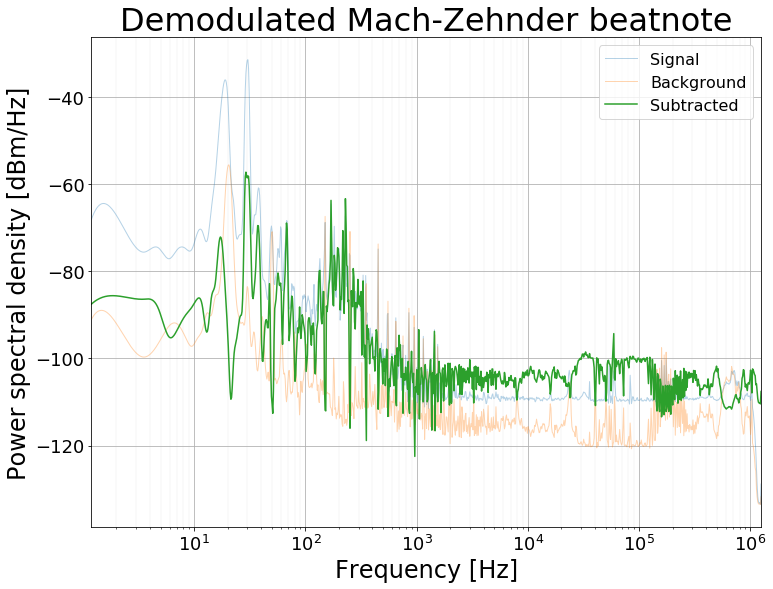

In [364]:
fileloc = 'Data\\20190910_markzehender' # Directory containing files

specfile = 'laser1binned.csv' # Spectrum file
bkgndfile = 'backgroundbinned.csv' # Background file

# Function to make appropiate strings
concat = lambda s: fileloc + '\\' + s

spec = MOGTrace(concat(specfile)) # Spectrum trace
bkgnd = MOGTrace(concat(bkgndfile)) # Background trace

traceplot(spec, bkgnd)

Analyse the Mach-Zehnder beatnote spectra

Laser linewidth of laser1 detemined to be 220.33 kHz. 
RMS values of voltage were 7.97 and 0.55 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of laser2 detemined to be 218.50 kHz. 
RMS values of voltage were 14.24 and 0.98 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of laser3 detemined to be 192.09 kHz. 
RMS values of voltage were 11.52 and 0.70 mV @ 30 Hz and up to 100 kHz respectively



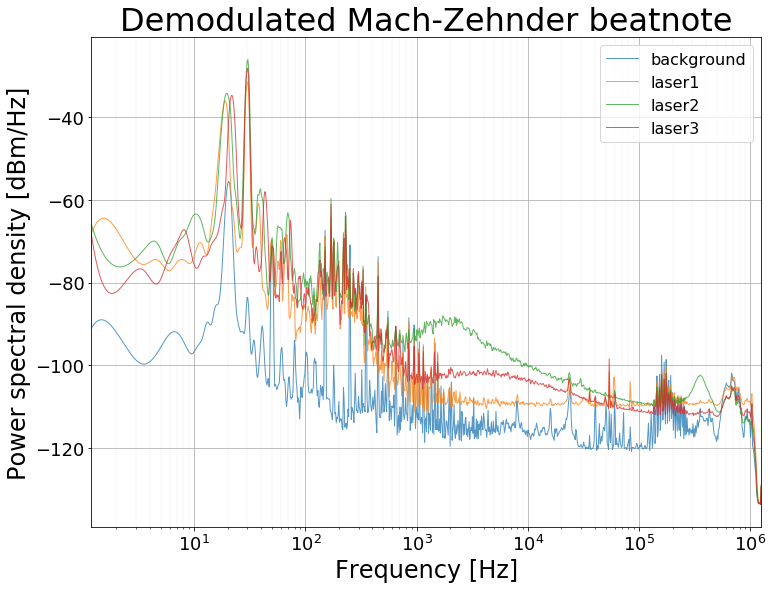

In [9]:
MZIrunner('Data\\20190910_markzehender')

# Usage for data analysis

Laser linewidth of Laser1 determined to be 469.72 kHz. 
RMS values of voltage were 367.83 and 54.28 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of Laser2 determined to be 486.29 kHz. 
RMS values of voltage were 366.22 and 55.95 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of Laser3 determined to be 462.18 kHz. 
RMS values of voltage were 369.71 and 53.68 mV @ 30 Hz and up to 100 kHz respectively



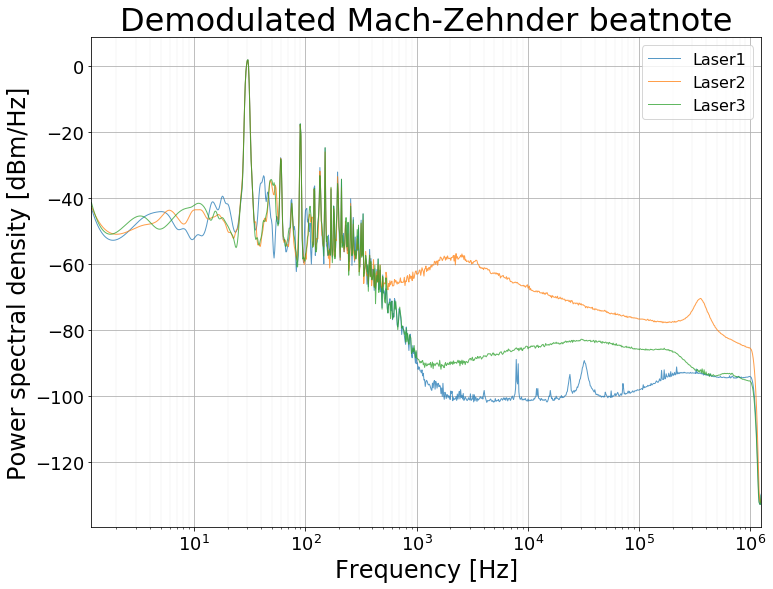

In [5]:
MZIrunner('Data\\20190918_Mach-Zehnder\\Set2')

In [16]:
(233/25)

9.32

In [17]:
(157/9)

17.444444444444443

In [18]:
def lol():
    print("lol")

In [19]:
lol()

lol


In [62]:
while True:
    task = input("What kind a spectra do should be analysed?\n1. Three-conrnered hat\n2. Mach-Zehnder beatnote\n3. Both\n")
    options = ['Three-conrnered hat', 'Mach-Zehnder beatnote', 'Both']
    options = map(str.lower, options)
    selections = range(1,4)
    choices = dict(zip(options, selections))
    try:
        int(task)
        
        if int(task) not in selections:
            print("Invalid choice. Enter a valid selection\n")
        else:
            
            break
            
    except ValueError:
        try:
            if task.lower() in map(str.lower, options):
                task = choices[task]
                break
                
        except AttributeError:
            pass
        print ("Invalid input. Enter a valid selection\n")
    
    task


What kind a spectra do should be analysed?
1. Three-conrnered hat
2. Mach-Zehnder beatnote
3. Both
 2


In [1]:
'a'.upper()

'A'

In [9]:
a = 1
if (a <= 1) and (a > 0):
    print('lol')

lol
